# Configuring GX Client

In [2]:
import os
from dotenv import load_dotenv
from groundx import GroundX

# Load environment variables from .env file
load_dotenv()

# Get API key from environment
api_key = os.getenv("GROUNDX_API_KEY")
if not api_key:
    raise ValueError("GROUNDX_API_KEY not found in .env file")

# Initialize client
client = GroundX(api_key=api_key)

# Looking Up Documents from a Particular Bucket

In [3]:
client.documents.lookup(
    id=20902,
    n=100
)

DocumentLookupResponse(count=100, documents=[DocumentDetail(bucket_id=20902, document_id='1e933a22-cc4d-490a-adb3-57a5e77ccf24', file_name='TipantaxiEBT.2023.10.30.pltf.pdf', file_size='1.3 MB', file_type='pdf', filter=None, process_id='ba2800ea-f587-48c1-acfb-f703c02e449a', search_data=None, source_url='https://claims-doc-uploader.s3.amazonaws.com/qa-groundx/20902/TipantaxiEBT.2023.10.30.pltf.pdf?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQDWe%2FkNo1%2FxiL8kWX1ZOPydVeZ1iPnZpWgpU7qk7jL0nwIhAPUW0XgTyk5YhWR4LjED9vKYajWpWeo6PZdLP4cynFLfKrQFCFQQAhoMOTAzNzEzMDQ2MjYxIgxpGYAiBcgo9JNzBZAqkQWyZSldYHBNQK5NCRu%2BcRvVO5D9p9GsrCak3nitl3rJWLIwQUdYLczwTL6PM2HKc7J7o0e%2FqDjVSVIcUsbsTHNWq9dCim%2FUtkcgchTJuT21EEt6RnD2c2XPqA%2BTiq0RVQ4JvvsrRTlNpXaocKV5%2BfEreyeoxG0a0lw1XPIRRtIBG0lBD1N1DvpLhItMfl8LMVeKAomngs5T7RsX6MCeMemPs8ROsyHqFJ%2FKuoIqHFc2v9TdeGZjh%2FadPLgQ9e8imlj8kXtRLTFc%2BqF6EMaQlH0%2Be5qmpuURD2KOuOkoK7JrYK0RQUuevraVdxijVhhfbwNtkfh9tcb3AMDbQ%2FBLBR

In [ ]:
def lookup_all_documents(doc_id: int, page_size: int = 100):
    """Retrieve all document chunks using nextToken pagination."""
    all_documents = []
    next_token = None

    while True:
        params = {"id": doc_id, "n": page_size}
        if next_token:
            params["next_token"] = next_token

        resp = client.documents.lookup(**params)
        print(resp)

        docs = resp.documents
        all_documents.extend(docs)

        # Check if there's another page
        next_token = resp.next_token
        if not next_token:
            break

    return all_documents

# Example usage
all_docs = lookup_all_documents(doc_id=20902, page_size=20)
print(f"Retrieved {len(all_docs)} documents total")

TypeError: DocumentsClient.lookup() got an unexpected keyword argument 'count'

In [14]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def fetch_xray_single(doc, timeout=30):
    """Download a single xray JSON safely."""
    file_name = getattr(doc, "file_name", None) or doc.get("fileName") or "unknown"
    xray_url = getattr(doc, "xray_url", None) or doc.get("xrayUrl")

    if not xray_url:
        return {"file_name": file_name, "error": "no xray_url"}

    try:
        resp = requests.get(xray_url, timeout=timeout)
        resp.raise_for_status()
        return {"file_name": file_name, "xray": resp.json()}
    except Exception as e:
        return {"file_name": file_name, "error": str(e)}

def fetch_all_xrays(all_docs, max_workers=10):
    """
    Multithreaded download of xrays with progress bar.
    
    Args:
        all_docs: list of dicts/objects with file_name/xray_url
        max_workers: number of threads
    
    Returns:
        List[dict]: each item has {"file_name": ..., "xray": ...} or {"error": ...}
    """
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_xray_single, doc): doc for doc in all_docs}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading xrays"):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                # This should rarely happen since fetch_xray_single is already error-safe
                doc = futures[future]
                file_name = getattr(doc, "file_name", None) or doc.get("fileName") or "unknown"
                results.append({"file_name": file_name, "error": f"unhandled: {e}"})
    return results

# Example usage
xray_data = fetch_all_xrays(all_docs, max_workers=10)
print(f"\n✅ Completed: {len(xray_data)} xrays fetched")
errors = [x for x in xray_data if "error" in x]
if errors:
    print(f"⚠️ {len(errors)} errors encountered")



✅ Completed: 526 xrays fetched
⚠️ 38 errors encountered


In [24]:
len(xray_data[3]['xray']['chunks'])

4

In [77]:
import tiktoken
import requests
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

enc = tiktoken.get_encoding("cl100k_base")

document_stats = []

# Worker function: fetch resolution for one multimodal chunk
def fetch_resolution(url, timeout=30):
    try:
        resp = requests.get(url, timeout=timeout)
        resp.raise_for_status()
        img = Image.open(BytesIO(resp.content))
        return {"width": img.width, "height": img.height}
    except Exception as e:
        return {"width": 0, "height": 0, "error": str(e)}

# Flatten list of all multimodal URLs across docs, keeping reference back to chunk
all_jobs = []
for document in xray_data:
    if "xray" not in document:
        continue

    num_pages = []
    for chunk in document["xray"].get("chunks", []):
        if chunk.get("boundingBoxes") is None:
            continue
        for bb in chunk["boundingBoxes"]:
            num_pages.append(bb["pageNumber"])
    if len(num_pages) == 0:
        continue
    max_pages = max(num_pages)

    doc_stats = {"num_pages": max_pages, "chunk_stats": []}

    for chunk in document["xray"]["chunks"]:
        chunk_stats = {}

        # Token counts
        text_fields = ["json", "narrative", "text"]
        for field in text_fields:
            if field in chunk:
                tokens = enc.encode(str(chunk[field]))
                chunk_stats[field] = len(tokens)

        # If multimodal, schedule for later parallel fetch
        if "multimodalUrl" in chunk:
            chunk_stats["is_multimodal"] = True
            url = chunk["multimodalUrl"]
            all_jobs.append((url, chunk_stats))  # link job back to stats dict

        doc_stats["chunk_stats"].append(chunk_stats)

    document_stats.append(doc_stats)

# Parallelize resolution fetching
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(fetch_resolution, url): (url, cs) for url, cs in all_jobs}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image resolutions"):
        url, chunk_stats = futures[future]
        result = future.result()
        chunk_stats["resolution"] = {"width": result["width"], "height": result["height"]}
        if "error" in result:
            print(f"⚠️ {url} → {result['error']}")

print(f"✅ Processed {len(document_stats)} documents with parallel image resolution lookup")


Fetching image resolutions: 100%|██████████| 2539/2539 [01:37<00:00, 26.00it/s]

✅ Processed 487 documents with parallel image resolution lookup


# Stats

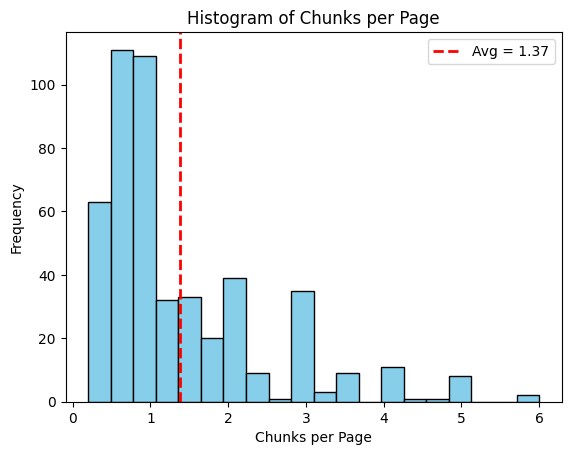

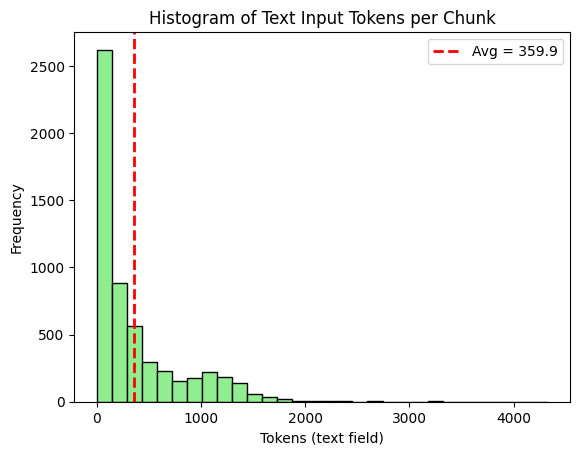

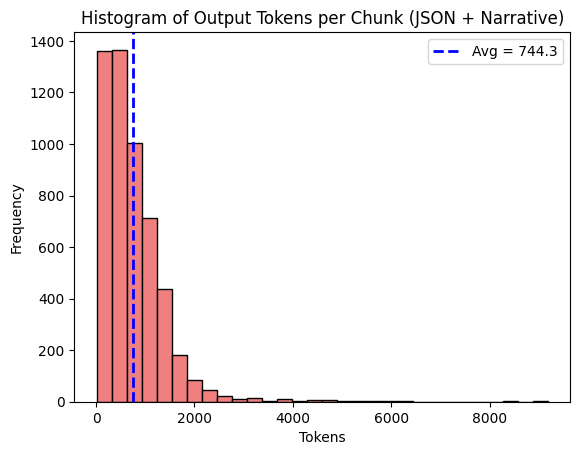

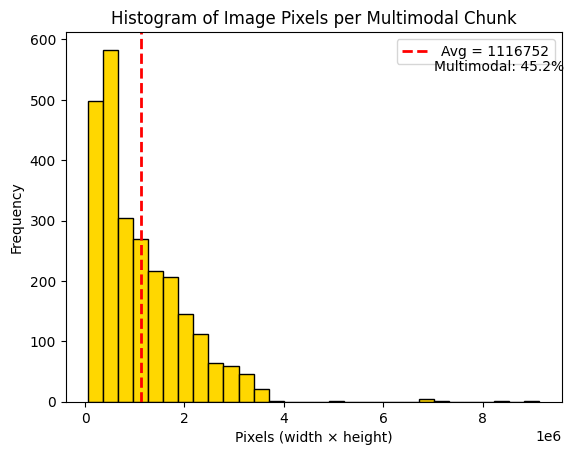

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# --- Flatten chunk stats ---
all_chunks = []
for doc in document_stats:
    all_chunks.extend(doc["chunk_stats"])

# --- 1. Histogram of chunks per page ---
chunks_per_page = []
for doc in document_stats:
    num_chunks = len(doc["chunk_stats"])
    num_pages = doc["num_pages"]
    if num_pages > 0:
        chunks_per_page.append(num_chunks / num_pages)

plt.hist(chunks_per_page, bins=20, color="skyblue", edgecolor="black")
plt.axvline(np.mean(chunks_per_page), color="red", linestyle="dashed", linewidth=2,
            label=f"Avg = {np.mean(chunks_per_page):.2f}")
plt.title("Histogram of Chunks per Page")
plt.xlabel("Chunks per Page")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- 2. Histogram of text input tokens per chunk ---
text_tokens = [c["text"] for c in all_chunks if "text" in c]
if text_tokens:
    plt.hist(text_tokens, bins=30, color="lightgreen", edgecolor="black")
    plt.axvline(np.mean(text_tokens), color="red", linestyle="dashed", linewidth=2,
                label=f"Avg = {np.mean(text_tokens):.1f}")
    plt.title("Histogram of Text Input Tokens per Chunk")
    plt.xlabel("Tokens (text field)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# --- 3. Histogram of output tokens per chunk (json + narrative) ---
output_tokens = []
for c in all_chunks:
    count = 0
    if "json" in c:
        count += c["json"]
    if "narrative" in c:
        count += c["narrative"]
    if count > 0:
        output_tokens.append(count)

if output_tokens:
    plt.hist(output_tokens, bins=30, color="lightcoral", edgecolor="black")
    plt.axvline(np.mean(output_tokens), color="blue", linestyle="dashed", linewidth=2,
                label=f"Avg = {np.mean(output_tokens):.1f}")
    plt.title("Histogram of Output Tokens per Chunk (JSON + Narrative)")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# --- 4. Histogram of number of pixels (width*height) ---
pixels = []
multimodal_chunks = 0
for c in all_chunks:
    if "is_multimodal" in c and "resolution" in c:
        w, h = c["resolution"]["width"], c["resolution"]["height"]
        pixels.append(w * h)
        multimodal_chunks += 1

if pixels:
    plt.hist(pixels, bins=30, color="gold", edgecolor="black")
    plt.axvline(np.mean(pixels), color="red", linestyle="dashed", linewidth=2,
                label=f"Avg = {np.mean(pixels):.0f}")
    plt.title("Histogram of Image Pixels per Multimodal Chunk")
    plt.xlabel("Pixels (width × height)")
    plt.ylabel("Frequency")
    plt.legend()

    multimodal_pct = (multimodal_chunks / len(all_chunks)) * 100 if all_chunks else 0
    plt.figtext(0.7, 0.8, f"Multimodal: {multimodal_pct:.1f}%", fontsize=10, color="black")
    plt.show()
